In [1]:
import torch, os, math, gzip, pickle
import matplotlib.pyplot as plt
from urllib.request import urlretrieve
from pathlib import Path

from torch import tensor
import torchvision as tv
import torchvision.transforms.functional as tvf
from torchvision import io
from torch.utils.cpp_extension import load_inline

In [2]:
def show_img(x, figsize=(4,3), **kwargs):
    plt.figure(figsize=figsize)
    plt.axis('off')
    if len(x.shape)==3: x = x.permute(1,2,0)  # CHW -> HWC
    plt.imshow(x.cpu(), **kwargs)

In [3]:
MNIST_URL='https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/data/mnist.pkl.gz?raw=true'
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path_gz = path_data/'mnist.pkl.gz'
if not path_gz.exists(): urlretrieve(MNIST_URL, path_gz)

In [4]:
with gzip.open(path_gz, 'rb') as f: ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train,y_train,x_valid,y_valid = map(tensor, (x_train,y_train,x_valid,y_valid))
x_train.shape,x_train.type()

(torch.Size([50000, 784]), 'torch.FloatTensor')

In [5]:
imgs = x_train.reshape((-1,28,28))
imgs.shape

torch.Size([50000, 28, 28])

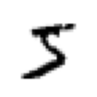

In [6]:
show_img(imgs[0], cmap='gray_r', figsize=(1,1))

In [7]:
torch.manual_seed(1)
weights = torch.randn(784,10)
weights

tensor([[-1.5256, -0.7502, -0.6540,  ..., -1.6091, -0.7121,  0.3037],
        [-0.7773, -0.2515, -0.2223,  ..., -1.1608,  0.6995,  0.1991],
        [ 0.8657,  0.2444, -0.6629,  ..., -1.4465,  0.0612, -0.6177],
        ...,
        [ 0.5063,  0.4656, -0.2634,  ...,  0.6452,  0.4298, -1.2936],
        [ 0.5171,  1.0315,  0.8120,  ..., -0.1046,  2.2588, -0.2793],
        [-1.4899,  0.3898, -0.5454,  ..., -0.1923, -0.5076,  0.5439]])

## Python Matmul

In [8]:
m1 = x_valid[:5]
m2 = weights
m1.shape, m2.shape

(torch.Size([5, 784]), torch.Size([784, 10]))

In [9]:
ar,ac = m1.shape  # -> n_rows * n_cols
br,bc = m2.shape
(ar, ac),(br, bc)

((5, 784), (784, 10))

In [10]:
t1 = torch.zeros(ar, bc)
t1.shape

torch.Size([5, 10])

In [11]:
for i in range(ar):
  for j in range(bc):
    for k in range(ac):
      t1[i,j] += m1[i,k] * m2[k,j]

In [12]:
t1.shape

torch.Size([5, 10])

In [13]:
import numpy as np
np.set_printoptions(precision=2, linewidth=140)
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)

In [14]:
t1

tensor([[-10.94,  -0.68,  -7.00,  -4.01,  -2.09,  -3.36,   3.91,  -3.44, -11.47,  -2.12],
        [ 14.54,   6.00,   2.89,  -4.08,   6.59, -14.74,  -9.28,   2.16, -15.28,  -2.68],
        [  2.22,  -3.22,  -4.80,  -6.05,  14.17,  -8.98,  -4.79,  -5.44, -20.68,  13.57],
        [ -6.71,   8.90,  -7.46,  -7.90,   2.70,  -4.73, -11.03, -12.98,  -6.44,   3.64],
        [ -2.44,  -6.40,  -2.40,  -9.04,  11.18,  -5.77,  -8.92,  -3.79,  -8.98,   5.28]])

In [15]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape,b.shape
  c = torch.zeros(ar,bc)
  for i in range(ar):
    for j in range(bc):
      for k in range(ac): c[i,j] += a[i,k] * b[k,j]

  return c

In [16]:
%time _=matmul(m1,m2)

CPU times: user 1.09 s, sys: 12.6 ms, total: 1.1 s
Wall time: 1.13 s


In [17]:
ar*bc*ac

39200

## 2D Python Kernel

In [18]:
from types import SimpleNamespace as ns

In [19]:
def blk_kernel2d(f, blocks, threads, *args):
  for i0 in range(blocks.y):
    for i1 in range(blocks.x):
      for j0 in range(threads.y):
        for j1 in range(threads.x): f(ns(x=i0,y=i1), ns(x=j0,y=j1), threads, *args)

In [20]:
def matmul_bk(blockidx, threadidx, blockdim, m, n, out, h, w, k):
  r = blockidx.y*blockdim.y + threadidx.y
  c = blockidx.x*blockdim.x + threadidx.x

  if(r>=h or c>=w): return
  o = 0.
  for i in range(k): o += m[r*k+i] * n[i*w+c]
  out[r*w+c] = o

In [21]:
def matmul_2d(m,n):
  h,k = m.shape
  k2,w = n.shape
  assert k==k2, "Size mismatch!"
  output = torch.zeros(h, w, dtype=m.dtype)
  tpb = ns(x=16, y=16)
  blocks = ns(x=math.ceil(w/tpb.x), y=math.ceil(h/tpb.y))
  blk_kernel2d(matmul_bk, blocks, tpb, m.flatten(),
               n.flatten(), output.flatten(), h, w, k)
  return output

In [22]:
res = matmul_2d(m1, m2)
torch.isclose(t1, res).all()

tensor(True)

## Broadcasting

In [23]:
def matmul(a,b):
  (ar,ac),(br,bc) = a.shape, b.shape
  c = torch.zeros(ar, bc)
  for i in range(ar): c[i] = (a[i,:,None]*b).sum(dim=0)
  return c

In [24]:
torch.isclose(t1,matmul(m1,m2)).all()

tensor(True)

In [25]:
%time _=matmul(m1, m2)

CPU times: user 1.27 ms, sys: 45 µs, total: 1.31 ms
Wall time: 1.58 ms


In [26]:
m1 = x_train
tr = matmul(m1,m2)
tr.shape

torch.Size([50000, 10])

In [27]:
%time _=matmul(m1,m2)

CPU times: user 2.21 s, sys: 30.2 ms, total: 2.24 s
Wall time: 3.35 s


In [28]:
ar,ac = m1.shape
br,bc = m2.shape
ar*bc*ac

392000000

## CUDA 3D

### CUDA Setup

In [29]:
os.environ['CUDA_LAUNCH_BLOCKING']='1'

In [30]:
%pip install -q wurlitzer ninja

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.9/422.9 kB 13.3 MB/s eta 0:00:00


In [31]:
%load_ext wurlitzer

In [32]:
def load_cuda(cuda_src, cpp_src, funcs, opt=False, verbose=False):
    return load_inline(cuda_sources=[cuda_src], cpp_sources=[cpp_src], functions=funcs,
                       extra_cuda_cflags=["-O2"] if opt else [], verbose=verbose, name="inline_ext")

In [33]:
cuda_begin = r'''
#include <torch/extension.h>
#include <stdio.h>
#include <c10/cuda/CUDAException.h>

#define CHECK_CUDA(x) TORCH_CHECK(x.device().is_cuda(), #x " must be a CUDA tensor")
#define CHECK_CONTIGUOUS(x) TORCH_CHECK(x.is_contiguous(), #x " must be contiguous")
#define CHECK_INPUT(x) CHECK_CUDA(x); CHECK_CONTIGUOUS(x)

inline unsigned int cdiv(unsigned int a, unsigned int b) { return (a + b - 1) / b;}
'''

### CUDA Kernel

In [34]:
cuda_src = cuda_begin + r'''
__global__ void matmul_k(float* m, float* n, float* out, int h, int w, int k) {
    int r = blockIdx.y*blockDim.y + threadIdx.y;
    int c = blockIdx.x*blockDim.x + threadIdx.x;

    if (r>=h || c>=w) return;
    float o = 0;
    for (int i = 0; i<k; ++i) o += m[r*k+i] * n[i*w+c];
    out[r*w+c] = o;
}

torch::Tensor matmul(torch::Tensor m, torch::Tensor n) {
    CHECK_INPUT(m); CHECK_INPUT(n);
    int h = m.size(0);
    int w = n.size(1);
    int k = m.size(1);
    TORCH_CHECK(k==n.size(0), "Size mismatch!");
    auto output = torch::zeros({h, w}, m.options());

    dim3 tpb(16,16);
    dim3 blocks(cdiv(w, tpb.x), cdiv(h, tpb.y));
    matmul_k<<<blocks, tpb>>>(
        m.data_ptr<float>(), n.data_ptr<float>(), output.data_ptr<float>(), h, w, k);
    C10_CUDA_KERNEL_LAUNCH_CHECK();
    return output;
}
'''

In [35]:
cpp_src = "torch::Tensor matmul(torch::Tensor m, torch::Tensor n);"

In [36]:
module = load_cuda(cuda_src, cpp_src, ['matmul'])

/usr/local/lib/python3.11/dist-packages/torch/utils/cpp_extension.py:1964: UserWarning: TORCH_CUDA_ARCH_LIST is not set, all archs for visible cards are included for compilation. 
If this is not desired, please set os.environ['TORCH_CUDA_ARCH_LIST'].
  warnings.warn(


In [37]:
m1c,m2c = m1.contiguous().cuda(), m2.contiguous().cuda()

In [38]:
torch.isclose(tr, module.matmul(m1c, m2c).cpu(), atol=1e-5).all()

tensor(True)

In [39]:
%%time
res=module.matmul(m1c, m2c).cpu()
res.shape

CPU times: user 6.86 ms, sys: 0 ns, total: 6.86 ms
Wall time: 6.27 ms


torch.Size([50000, 10])

## PyTorch

In [40]:
torch.isclose(tr, (m1c@m2c).cpu(), atol=1e-5).all()

tensor(True)

In [41]:
%timeit -n 10 _=(m1c@m2c).cpu()

2.18 ms ± 197 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
